In [1]:
%load_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
import sys

sys.path.append("/home/dchen/BA_CH_EN/")

# Basics
import tensorflow as tf
import xarray as xr
import pandas as pd

# Helpful
from tqdm import tqdm

# Visualization
import matplotlib.pyplot as plt

# My Methods
from src.utils.CRPS import *  # CRPS metrics
from src.utils.data_split import *  # Splitting data into X and y
from src.utils.drn_make_X_array import *  # Import make train array functions (make_X_array)
from src.models.EMOS import *  # EMOS implementation
from src.models.DRN.DRN_model import *  # DRN implementation
from src.models.EMOS_global.EMOS_global_load_score import *  # Load EMOS_global_scores
from src.models.EMOS_global.EMOS_global_load_model import *  # Load EMOS_global_models
import data.raw.load_data_raw as ldr  # Load raw data
import data.processed.load_data_processed as ldp  # Load processed data normed
import data.processed.load_data_processed_denormed as ldpd  # Load processed data denormed
from src.models.CRPS_baseline.CRPS_load import *  # Load CRPS scores
from src.models.U_net.unet import Unet
from src.models.U_net.u_net_tests_params import *
from src.models.U_net.unet import *

<IPython.core.display.Javascript object>

### 0. Set Up

In [3]:
lead_time = 0
var_num = 2

land_sea_mask_dummy = np.load(
    "/Data/Delong_BA_Data/land_sea_mask_dummy/land_sea_mask_dummy.npy"
)
land_sea_mask_dummy = pad_land_sea_mask(land_sea_mask_dummy)
land_sea_mask_dummy = np.repeat(land_sea_mask_dummy[np.newaxis, ...], 357, axis=0)

# load data
test_var_mean = []
test_var_std = []
test_var_y = []
for var in range(6):
    (
        padded_test_data_mean,
        padded_test_data_std,
        padded_test_data_y,
    ) = u_net_load_test_data(var, lead_time)
    test_var_mean.append(padded_test_data_mean)
    test_var_std.append(padded_test_data_std)
    test_var_y.append(padded_test_data_y)

# Then, pack all of your input data into a list
test_inputs = test_var_mean + test_var_std + [land_sea_mask_dummy]

test_target = test_var_y[var_num]

<IPython.core.display.Javascript object>

In [4]:
def plot_losses(csv_filepath, starting_epoch=0, ending_epoch=1000000000):
    # Load the csv file into a pandas DataFrame
    data = pd.read_csv(csv_filepath).iloc[starting_epoch:ending_epoch]

    # Create a new figure
    plt.figure(figsize=(10, 5))

    # Plot the training loss
    plt.plot(data["epoch"], data["loss"], label="Train Loss")

    # Plot the validation loss
    plt.plot(data["epoch"], data["val_loss"], label="Validation Loss")

    # Set the labels for the x and y axes
    plt.xlabel("Epochs")
    plt.ylabel("Loss")

    # Set the title for the plot
    plt.title("Training and Validation Loss")

    # Enable the legend
    plt.legend()

    # Display the plot
    plt.show()
    return data

<IPython.core.display.Javascript object>

In [5]:
def test_best_model(path, var_num, lead_time):

    model = tf.keras.models.load_model(
        path,
        custom_objects={
            "crps_cost_function_U": crps_cost_function_U,
            "crps_cost_function_trunc_U": crps_cost_function_trunc_U,
        },
    )
    # load land_sea_mask
    land_sea_mask_dummy = np.load(
        "/Data/Delong_BA_Data/land_sea_mask_dummy/land_sea_mask_dummy.npy"
    )
    land_sea_mask_dummy = pad_land_sea_mask(land_sea_mask_dummy)
    land_sea_mask_dummy = np.repeat(land_sea_mask_dummy[np.newaxis, ...], 357, axis=0)
    # load data
    test_var_mean = []
    test_var_std = []
    test_var_y = []
    for var in range(6):
        (
            padded_test_data_mean,
            padded_test_data_std,
            padded_test_data_y,
        ) = u_net_load_test_data(var, lead_time)
        test_var_mean.append(padded_test_data_mean)
        test_var_std.append(padded_test_data_std)
        test_var_y.append(padded_test_data_y)

    # Then, pack all of your input data into a list
    test_inputs = test_var_mean + test_var_std + [land_sea_mask_dummy]

    test_target = test_var_y[var_num]

    scores = model.evaluate(test_inputs, test_target, verbose=1)
    return scores

<IPython.core.display.Javascript object>

### Run 1:

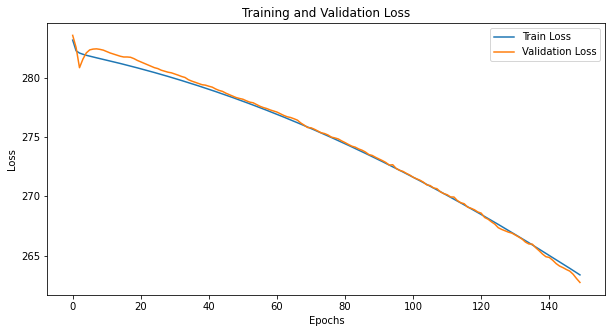

,epoch,loss,val_loss
0,0,283.153992,283.555328
1,1,282.252716,282.530060
2,2,282.065063,280.831268
3,3,281.963440,281.551117
4,4,281.875671,282.076324
...,...,...,...
145,145,264.116669,263.834778
146,146,263.933044,263.697632
147,147,263.749084,263.432617
148,148,263.565308,263.070068


<IPython.core.display.Javascript object>

In [52]:
plot_losses(
    "/Data/Delong_BA_Data/models/U_net/csv_log/_training_log_var_2_lead_0_lr_0.0001_ep_150_bs_64_filters16.csv"
)

### Run 2:

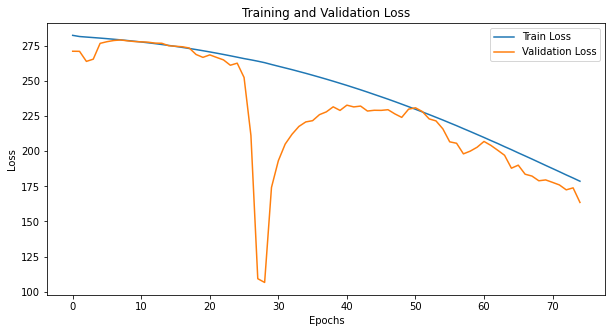

,epoch,loss,val_loss
0,0,282.567444,271.248749
1,1,281.735352,271.186279
2,2,281.351624,264.023102
3,3,280.985107,265.606812
4,4,280.612213,276.867004
...,...,...,...
70,70,187.699295,177.850891
71,71,185.459946,176.032608
72,72,183.157837,172.531754
73,73,180.961685,173.949570


<IPython.core.display.Javascript object>

In [53]:
plot_losses(
    "/Data/Delong_BA_Data/models/U_net/csv_log/_training_log_var_2_lead_0_lr_0.001_ep_150_bs_128_filters16.csv"
)

### Run 3

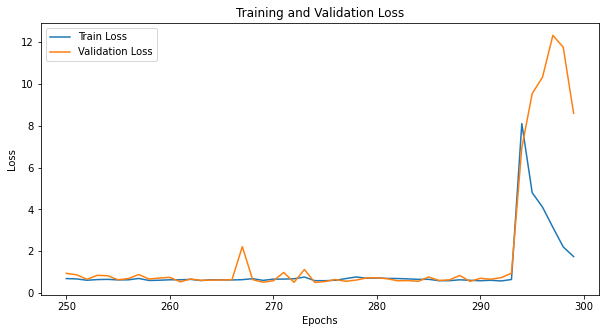

<IPython.core.display.Javascript object>

In [13]:
df_3 = plot_losses(
    "/Data/Delong_BA_Data/models/U_net/csv_log/_training_log_var_2_lead_0_lr_0.001_ep_300_bs_128_filters20.csv",
    250,
    300,
)

In [5]:
model = tf.keras.models.load_model(
    "/Data/Delong_BA_Data/models/U_net/models/_unet_model_var_2_lead_0_lr_0.001_ep_300_bs_128_filters20.h5"
)

2023-07-05 17:55:37.703841: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-05 17:55:39.080251: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory:  -> device: 0, name: NVIDIA RTX A5000, pci bus id: 0000:17:00.0, compute capability: 8.6
2023-07-05 17:55:39.080797: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 18881 MB memory:  -> device: 1, name: NVIDIA RTX A5000, pci bus id: 0000:65:00.0, compute capability: 8.6
2023-07-05 17:55:49.247214: W tensorflow/core/common_runtime/bfc_allocator.cc:462] Allocator (GPU_0_bfc) ran out of memory trying to allocate 

ResourceExhaustedError: failed to allocate memory [Op:Mul]

<IPython.core.display.Javascript object>

### Run 4

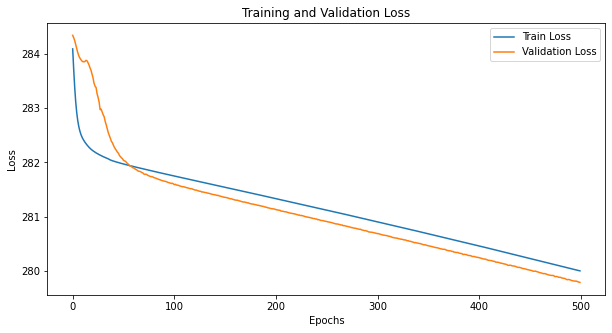

<IPython.core.display.Javascript object>

In [10]:
df_run_4 = plot_losses(
    "/Data/Delong_BA_Data/models/U_net/csv_log/_training_log_var_2_lead_0_lr_1e-05_ep_500_bs_128_filters20.csv"
)

### Run 5

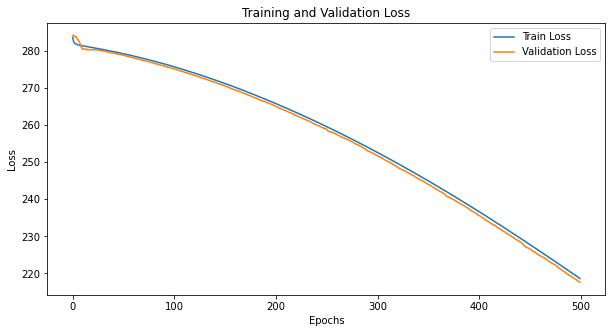

<IPython.core.display.Javascript object>

In [14]:
df_run_5 = plot_losses(
    "/Data/Delong_BA_Data/models/U_net/csv_log/_training_log_var_2_lead_0_lr_0.0001_ep_500_bs_128_filters24.csv"
)

In [15]:
df_run_5

,epoch,loss,val_loss
0,0,283.558380,284.089417
1,1,282.403137,284.142609
2,2,281.979218,283.778687
3,3,281.819305,283.861938
4,4,281.692719,283.352783
...,...,...,...
495,495,219.408401,218.469101
496,496,219.220200,218.147034
497,497,219.031815,217.960876
498,498,218.843414,217.822937


<IPython.core.display.Javascript object>

### Run 6

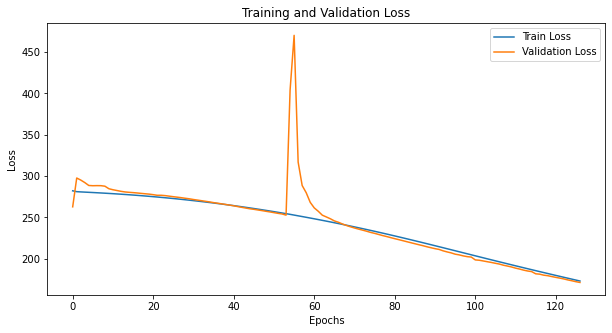

<IPython.core.display.Javascript object>

In [19]:
df_run_6 = plot_losses(
    "/Data/Delong_BA_Data/models/U_net/csv_log/_training_log_var_2_lead_0_lr_0.0005_ep_3000_bs_128_filters24.csv",
)

In [20]:
df_run_6

,epoch,loss,val_loss
0,0,282.144592,262.781219
1,1,281.121338,297.620850
2,2,280.826385,295.140228
3,3,280.572449,292.115753
4,4,280.325439,288.597992
...,...,...,...
122,122,177.582581,175.578934
123,123,176.452057,174.384445
124,124,175.325089,173.371719
125,125,174.201523,172.253891


<IPython.core.display.Javascript object>

In [16]:
score_run_6 = test_best_model(
    "/Data/Delong_BA_Data/models/U_net/models/_unet_model_var_2_lead_0_lr_0.0005_ep_3000_bs_128_filters24.h5",
    2,
    0,
)

2023-07-06 09:49:05.968921: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-06 09:49:07.341828: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory:  -> device: 0, name: NVIDIA RTX A5000, pci bus id: 0000:17:00.0, compute capability: 8.6
2023-07-06 09:49:07.342343: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 18878 MB memory:  -> device: 1, name: NVIDIA RTX A5000, pci bus id: 0000:65:00.0, compute capability: 8.6
2023-07-06 09:49:17.368307: W tensorflow/core/common_runtime/bfc_allocator.cc:462] Allocator (GPU_0_bfc) ran out of memory trying to allocate 

KeyboardInterrupt: 

<IPython.core.display.Javascript object>

### Run 7

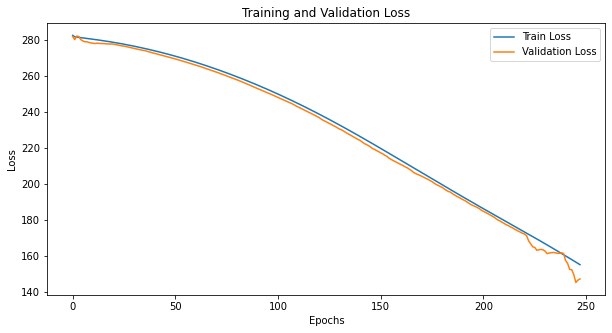

<IPython.core.display.Javascript object>

In [21]:
df_run_7 = plot_losses(
    "/Data/Delong_BA_Data/models/U_net/csv_log/_training_log_var_2_lead_0_lr_0.0003_ep_3000_bs_128_filters24.csv"
)

In [22]:
df_run_7

,epoch,loss,val_loss
0,0,282.536072,281.936432
1,1,281.727844,280.160065
2,2,281.557953,282.133759
3,3,281.402832,281.851379
4,4,281.249878,280.122223
...,...,...,...
243,243,157.792267,152.159027
244,244,157.093994,149.375778
245,245,156.393280,145.091354
246,246,155.687225,146.367249


<IPython.core.display.Javascript object>